# Marijuana Sales Prediction

## Projects Objective
- Goal: Predict sales of each brand
- Sub-problems: 

## Import Required Libraries

In [1]:
# import systems tools 
import os 
import sys

# import numerical tools
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import warnings


## Load Data
- Load from local dataset

In [2]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
# import required packages
import sys
import os
import pandas as pd
# Load Dataset
avgRetail = pd.read_csv("../data/BrandAverageRetailPrice.csv")
brandDetail = pd.read_csv("../data/BrandDetails.csv")
totalSales = pd.read_csv("../data/BrandTotalSales.csv")
totalUnits = pd.read_csv("../data/BrandTotalUnits.csv")

## Construct Dataset 
- Time-series data
    - Convert into same time-stamp format
- Clean Data 
    - without imputation
- Feature Engineering
    - Feature augmentation
    - Combining feature in same/different datasets

### Find the dataset to start with
- Criteria: Information of each datasets
- Objective: Since the final goal is to predict the future sales, we start with the dataset that seems to have strong correlation with sales, and also with few feature to start with. 

#### Total Sales dataset

In [3]:
totalSales.info()
totalSales.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25279 entries, 0 to 25278
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Months           25279 non-null  object
 1   Brand            25279 non-null  object
 2   Total Sales ($)  25279 non-null  object
dtypes: object(3)
memory usage: 592.6+ KB


,Months,Brand,Total Sales ($)
0,09/2018,10x Infused,"1,711.334232"
1,09/2018,1964 Supply Co.,"25,475.21594500000"
2,09/2018,3 Bros Grow,"120,153.644757"
3,09/2018,3 Leaf,"6,063.5297850000000"
4,09/2018,350 Fire,"631,510.0481550000"


#### Total units dataset

In [4]:
totalUnits.info()
totalUnits.head(5)
# find out how many brand do we have currently

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27686 entries, 0 to 27685
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Brands            27686 non-null  object 
 1   Months            27686 non-null  object 
 2   Total Units       25712 non-null  object 
 3   vs. Prior Period  24935 non-null  float64
dtypes: float64(1), object(3)
memory usage: 865.3+ KB


,Brands,Months,Total Units,vs. Prior Period
0,#BlackSeries,08/2020,"1,616.3390040000000",NaN
1,#BlackSeries,09/2020,NaN,-1.000000
2,#BlackSeries,01/2021,715.5328380000000,NaN
3,#BlackSeries,02/2021,766.669135,0.071466
4,#BlackSeries,03/2021,NaN,-1.000000


### Clean the choosen dataset
- Selected dataset: Total Sales
- Breakdown: Base-on different brand
- Reason: 
    - It contains more information about salses. 
    - It has much narrow data in brand features. 

#### Preprocess the selected dataset

In [5]:
# convert the time stamp dataset
totalSales["Months"] = totalSales["Months"].astype(str).astype('datetime64[ns]')
# convert salses data to numerical data form
totalSales["Total Sales ($)"] = totalSales["Total Sales ($)"].str.replace(',','')
totalSales["Total Sales ($)"] = totalSales["Total Sales ($)"].astype(float)
totalSales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25279 entries, 0 to 25278
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Months           25279 non-null  datetime64[ns]
 1   Brand            25279 non-null  object        
 2   Total Sales ($)  25279 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 592.6+ KB


#### Find out all the brand name

In [6]:
brands = list(totalSales["Brand"].unique())
print("==================================")
print("Total: {} different brands".format(brands.__len__()))
print("==================================")

Total: 1627 different brands


#### Select Brand with Enough Data
- Start with the brand that has much information. 

============Current Threshold for Number of Data: 37===========


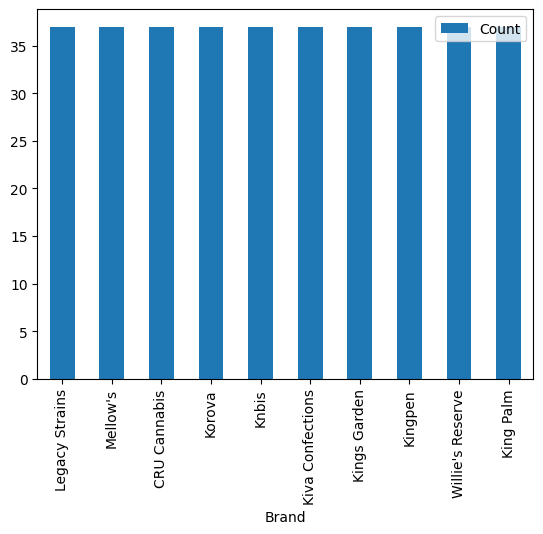

In [7]:
import matplotlib.pyplot as plt
# start with one of the brand
# only list-out top three brand
brands_data_num = pd.DataFrame()
brands_data_num.loc[:, "Brand"] = totalSales.loc[:, "Brand"]
brands_data_num.loc[:, "Count"] = [1]*len(totalSales["Brand"])
brands_data_num = brands_data_num.groupby(["Brand"]).sum().sort_values("Count", ascending=False)

# Only pick the brands with enough number of data
numDataThreshold = brands_data_num["Count"].max()
print("============Current Threshold for Number of Data: {}===========".format(numDataThreshold))
brands_filtered = brands_data_num[brands_data_num.Count >= numDataThreshold]
brands_filtered.head(10).plot(kind="bar")
plt.show()

### Feature Engineering 
- Transform and add more features in the selected dataset. 
- Add more features from other related datasets. 

#### Sales info about selected brand

In [8]:
brandName = "Kingpen"
brandData = totalSales[totalSales.Brand == brandName].drop(['Brand'], 1)

#### Adding Features to Dataset

In [9]:
#  adding from current dataset 
#==============add last month data===============================================
brandData.loc[:, 'Previous Month Sales'] = brandData.loc[:,"Total Sales ($)"].shift(-1)

#===========Adding Rolling Sales Data===========
# add rolling sales data (for three months)
# calcualte the sum
rollSum, rollMonths = 0, 3
for month in range(1, rollMonths + 1): 
    rollSum += brandData.loc[:,"Total Sales ($)"].shift(-1 * month)
brandData.loc[:, 'Rolling Sales (3 months)'] = rollSum / rollMonths

# add rolling sales data (for six months)
rollSum, rollMonths = 0, 6
for month in range(1, rollMonths + 1): 
    rollSum += brandData.loc[:,"Total Sales ($)"].shift(-1 * month)
brandData.loc[:, 'Rolling Sales (6 months)'] = rollSum / rollMonths

brandData.head()

,Months,Total Sales ($),Previous Month Sales,Rolling Sales (3 months),Rolling Sales (6 months)
234,2018-09-01,1.114443e+06,2.632638e+06,2.550175e+06,2.439767e+06
708,2018-10-01,2.632638e+06,2.443997e+06,2.402470e+06,2.389068e+06
1209,2018-11-01,2.443997e+06,2.573889e+06,2.349194e+06,2.379411e+06
1745,2018-12-01,2.573889e+06,2.189523e+06,2.329359e+06,2.327181e+06
2282,2019-01-01,2.189523e+06,2.284169e+06,2.375666e+06,2.369494e+06


##### Add from total_unit dataset

In [10]:
# general info
brandUnits = totalUnits[totalUnits.Brands == brandName]
brandUnits["Months"] = pd.to_datetime(brandUnits["Months"])
brandUnits["Total Units"] = brandUnits["Total Units"].str.replace(',','')
brandUnits["Total Units"] = brandUnits["Total Units"].astype(float)
brandUnits = brandUnits.drop(['Brands'], 1)
#===================Merge Data==================
brandData = brandData.merge(brandUnits, right_on="Months", left_on="Months")
brandData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 0 to 36
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Months                    37 non-null     datetime64[ns]
 1   Total Sales ($)           37 non-null     float64       
 2   Previous Month Sales      36 non-null     float64       
 3   Rolling Sales (3 months)  34 non-null     float64       
 4   Rolling Sales (6 months)  31 non-null     float64       
 5   Total Units               37 non-null     float64       
 6   vs. Prior Period          37 non-null     float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 2.3 KB


##### Add from average retail price dataset

In [11]:
# Convert months column data into datetime
brandARP = avgRetail[avgRetail.Brands == brandName].drop(['Brands'], 1)
brandARP["Months"] = pd.to_datetime(brandARP["Months"])
# rename the features name
# since in the total_units dataset, ther is also a feature
# called "vs. Prior Period"
brandARP = brandARP.rename(columns={"vs. Prior Period" : "vs. Prior Period (ARP)"})

# merge the feature into the sales dataset)
brandData = brandData.merge(brandARP, left_on="Months", right_on="Months")
brandData = brandData.rename(columns={"vs. Prior Period" : "vs. Prior Period (Totla Units)"})
brandData.head(10)

,Months,Total Sales ($),Previous Month Sales,Rolling Sales (3 months),Rolling Sales (6 months),Total Units,vs. Prior Period (Totla Units),ARP,vs. Prior Period (ARP)
0,2018-09-01,1.114443e+06,2.632638e+06,2.550175e+06,2.439767e+06,31631.770954,-0.128840,35.231759,NaN
1,2018-10-01,2.632638e+06,2.443997e+06,2.402470e+06,2.389068e+06,66336.619936,1.097152,39.686045,0.126428
2,2018-11-01,2.443997e+06,2.573889e+06,2.349194e+06,2.379411e+06,66353.701500,0.000257,36.832871,-0.071894
3,2018-12-01,2.573889e+06,2.189523e+06,2.329359e+06,2.327181e+06,72071.127847,0.086166,35.713177,-0.030399
4,2019-01-01,2.189523e+06,2.284169e+06,2.375666e+06,2.369494e+06,58684.322068,-0.185744,37.310181,0.044717
5,2019-02-01,2.284169e+06,2.514385e+06,2.409628e+06,2.303442e+06,58428.103252,-0.004366,39.093676,0.047802
6,2019-03-01,2.514385e+06,2.328444e+06,2.325002e+06,2.112088e+06,63988.879474,0.095173,39.294101,0.005127
7,2019-04-01,2.328444e+06,2.386055e+06,2.363321e+06,1.914987e+06,62542.924670,-0.022597,37.229531,-0.052541
8,2019-05-01,2.386055e+06,2.260507e+06,2.197255e+06,1.667668e+06,65992.881402,0.055161,36.156253,-0.028829
9,2019-06-01,2.260507e+06,2.443401e+06,1.899174e+06,1.480768e+06,65244.831215,-0.011335,34.646529,-0.041756


##### Add from brand details dataset

In [12]:
import numpy as np
# info aobut brain details
bdData = brandDetail[brandDetail.Brand == brandName]

bdColNames = bdData.columns.tolist()
for feature in bdColNames: 
    print(feature)

State
Channel
Category L1
Category L2
Category L3
Category L4
Category L5
Brand
Product Description
Total Sales ($)
Total Units
ARP
Flavor
Items Per Pack
Item Weight
Total THC
Total CBD
Contains CBD
Pax Filter
Strain
Is Flavored
Mood Effect
Generic Vendor
Generic Items
$5 Price Increment


##### L1 Category Analysis 
- Find out which type of products has largest portion in the total sales
- Conclusion: 
    1. Inhaleables and Ingestibles type of product has the largest portion of income sales. 

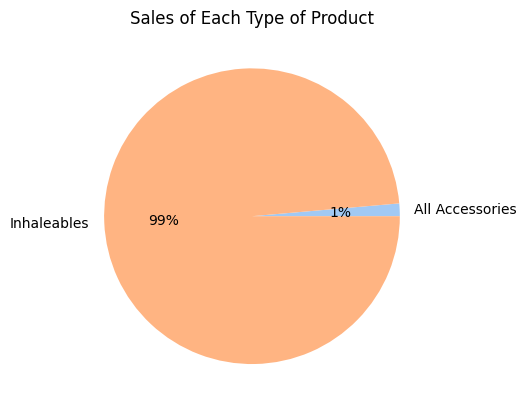

In [89]:
#features = ["Category L1"] 
#index = bdData["Category L1"].value_counts().index.to_list()
#val = bdData["Category L1"].value_counts().to_list()

brandSales = pd.DataFrame()
studyData = bdData.copy()
brandSales.loc[:, "Category"] = studyData.loc[:, "Category L1"]
brandSales.loc[:, "Sales"] = studyData.loc[:, "Total Sales ($)"].str.replace(',', '').astype(float)
brandSales = brandSales.groupby(by="Category").sum()
brandSalesIndex = brandSales.index
colors = sns.color_palette('pastel')[0:5]
plt.title("Sales of Each Type of Product")
plt.pie(brandSales["Sales"], labels=brandSalesIndex, colors=colors, autopct='%.0f%%')
plt.show()

#### Explore Different Category Licences Data

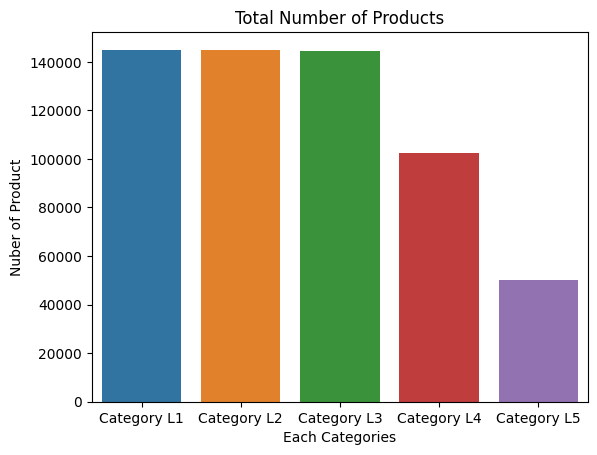

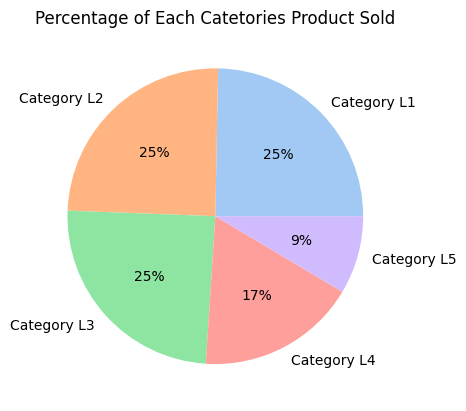

In [13]:
catExplore = brandDetail.copy()

# Each categories portion charts
catIndex = ["Category L" + str(x) for x in range(1, 6) ]
catNum = [sum(catExplore[x].value_counts(dropna=True)) for x in catIndex] # total number of product of each categories 
catSubNum = [len(catExplore[x].value_counts(dropna=True)) for x in catIndex] # number of total types of products in each categories

catData = pd.DataFrame()
catData.loc[:, "Category"] = catIndex
catData.loc[:, "Total_Num_of_Products"] = catNum
catData.loc[:, "Total_Num_of_Products(%)"] = [num/sum(catNum) for num in catNum]
catData.loc[:, "Total_Num_of_Types"] = catSubNum

sns.barplot(catData, x="Category", y = "Total_Num_of_Products")
plt.xlabel("Each Categories")
plt.ylabel("Nuber of Product")
plt.title("Total Number of Products")
plt.show()

colors = sns.color_palette('pastel')[0:5]
plt.title("Percentage of Each Catetories Product Sold")
plt.pie(catData["Total_Num_of_Products(%)"], labels=catIndex, colors=colors, autopct='%.0f%%')
plt.show()

##### Adding "Category L1" and "Category L2" as new features
- Categories L1 and L2 are the most common sold product. 
- In L1: 

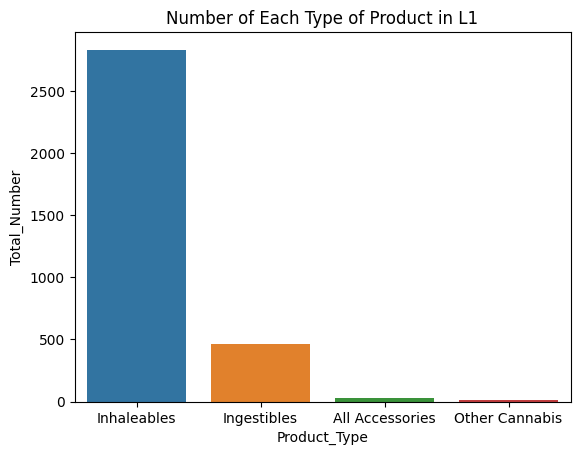

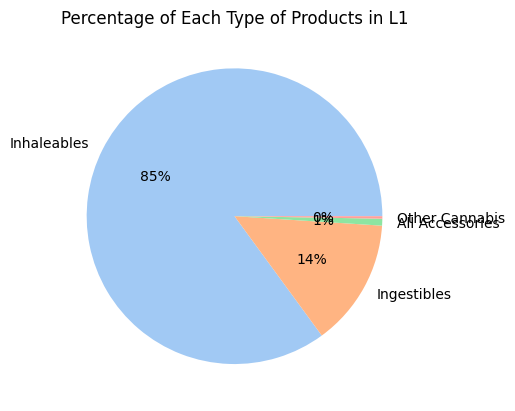

In [14]:
# Compare L1 Categories in different brand
L1_comp = dict()
for brand in brands_filtered.index[0:10]:
    bdTempt = brandDetail[brandDetail.Brand == brand]
    L1_types = bdTempt["Category L1"].value_counts().index
    L1_values = bdTempt["Category L1"].value_counts().values
    L1_tempt = dict(zip(L1_types, L1_values))
    for key, value in L1_tempt.items(): 
        if L1_comp.get(key) is None: 
            L1_comp[key] = value
        else: 
            L1_comp[key] += value

L1_comp_df = pd.DataFrame()
L1_comp_df.loc[:, "Product_Type"] = [x for x, _ in L1_comp.items()]
L1_comp_df.loc[:, "Total_Number"] = [x for _, x in L1_comp.items()]
L1_comp_df.loc[:, "Percentage"] = [x/sum(L1_comp_df["Total_Number"].values) for _, x in L1_comp.items()]
L1_comp_df.head()
sns.barplot(data=L1_comp_df, x='Product_Type', y= "Total_Number").set(title="Number of Each Type of Product in L1")
plt.show()

fig, ax = plt.subplots(1,1)
colors = sns.color_palette('pastel')[0:5]
plt.title("Percentage of Each Type of Products in L1")
ax.pie(L1_comp_df["Percentage"], labels=L1_comp_df["Product_Type"], colors=colors, autopct='%.0f%%')
plt.show()

## Explore Data 
- Visualize Data 
- Explore data (correlation)
- Objective of features combination

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns

## Data Preprocessing
- Develope several pipeline
- Visualize pipelines 
- (pipeline update -- base on training result) 

In [16]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline



## Hyper-parameters
- Test/Train ratio
- Hyperparameters for traning
- Hyperparameters for model 

## Split Datasets
- Split into training/validation and testing dataset

In [17]:
from sklearn.model_selection import train_test_split

## Deploy ML/DL
- Model selection
- Comparison between each baseline models
- Select best baseline model
- Search for best parameters (grid/random search)

## Visualize Result 
- Visualization result
    - Tableau
    - Seaborn
- Check important features 
    - Go back to exploring data (if necessary)